In [1]:
MODEL_NAME = 'MODEL_4'

In [2]:
import pandas as pd
import numpy as np
import datasets
import yaml

with open('input_params/input_params.yaml') as f:
    
    PARAMS = yaml.load(f, Loader=yaml.FullLoader)
    PARAMS = PARAMS[MODEL_NAME]
    
    # read data params
    SENT_LEN = PARAMS['READ_DATA_PARAMS']['SENT_LEN']
    KIND = PARAMS['READ_DATA_PARAMS']['KIND']
    # vocab params
    MAX_LEN = PARAMS['VOCAB_PARAMS']['MAX_LEN']
    MIN_LEN = PARAMS['VOCAB_PARAMS']['MIN_LEN']
    NUM_WORDS = PARAMS['VOCAB_PARAMS']['NUM_WORDS']
    # model params
    BATCH_SIZE = PARAMS['MODEL_PARAMS']['BATCH_SIZE']
    DROP_PROB = PARAMS['MODEL_PARAMS']['DROP_PROB']
    EMBEDDING_DIMS = PARAMS['MODEL_PARAMS']['EMBEDDING_DIMS']
    RNN_UNITS = PARAMS['MODEL_PARAMS']['RNN_UNITS']
    ATTENTION_UNITS = PARAMS['MODEL_PARAMS']['ATTENTION_UNITS']
    IF_USE_ATTENTION = PARAMS['MODEL_PARAMS']['IF_USE_ATTENTION']
    TRAINABLE_EMBEDDING = PARAMS['MODEL_PARAMS']['TRAINABLE_EMBEDDING']
    ENCODER_CONFIG = PARAMS['MODEL_PARAMS']['ENCODER_CONFIG']
    DECODER_CONFIG = PARAMS['MODEL_PARAMS']['DECODER_CONFIG']
    # train params
    EPOCHS = PARAMS['TRAIN_PARAMS']['EPOCHS']
    EVAL_FREQ = PARAMS['TRAIN_PARAMS']['EVAL_FREQ']
    SAVE_PATH = PARAMS['TRAIN_PARAMS']['SAVE_PATH']

# Load data

In [3]:
cornell = datasets.readCornellData('cornell/', max_len=SENT_LEN, kind=KIND)

100%|██████████| 83097/83097 [00:23<00:00, 3482.00it/s]


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_frq_dist(sent):
    sent_len = [len(i.split(' ')) for i in sent]

    len_frq = {}

    for i in sent_len:
        try:
            len_frq[i] += 1
        except:
            len_frq[i] = 1

    frq = [i for (i, j) in sorted(len_frq.items())]
    cnt = [j for (i, j) in sorted(len_frq.items())]

    plt.plot(frq, np.cumsum(cnt) / np.sum(cnt))

In [5]:
START_TOKEN = '<start>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

sentences = [START_TOKEN + ' ' + i[0] + ' ' + EOS_TOKEN for i in cornell]
replies = [START_TOKEN + ' ' + i[1] + ' ' + EOS_TOKEN for i in cornell]

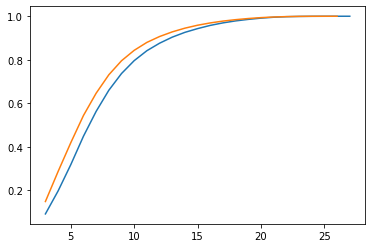

In [6]:
plot_frq_dist(sentences)
plot_frq_dist(replies)

In [7]:
len(sentences), len(replies)

(210572, 210572)

# Tokenization

In [8]:
sent_mask = [MIN_LEN <= len(i.split(' ')) <= MAX_LEN for i in sentences]
replies_mask = [MIN_LEN <= len(i.split(' ')) <= MAX_LEN for i in replies]
full_mask = [i and j for (i, j) in zip(sent_mask, replies_mask)]

sentences = np.array(sentences)[full_mask].tolist()
replies = np.array(replies)[full_mask].tolist()

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, filters='', oov_token=UNK_TOKEN)
tokenizer.fit_on_texts(sentences + replies)

sentences_en = tokenizer.texts_to_sequences(sentences)
replies_en = tokenizer.texts_to_sequences(replies)

sentences_en = tf.keras.preprocessing.sequence.pad_sequences(sentences_en, maxlen=None, padding='post', value=0)
replies_en = tf.keras.preprocessing.sequence.pad_sequences(replies_en, maxlen=None, padding='post', value=0)

X_train, X_test, y_train, y_test = train_test_split(sentences_en, replies_en, test_size=0.05, random_state=12345)

In [10]:
def max_len(tensor):
    return max(len(t) for t in tensor)

# Model Parameters

In [11]:
# train params
BUFFER_SIZE = len(X_train)
STEPS_PER_EPOCH = BUFFER_SIZE//BATCH_SIZE

# seq params
VOCAB_SIZE = min(NUM_WORDS, len(tokenizer.word_index)) + 2 # + 1 for padding symbol
Tx = max_len(sentences_en)
Ty = max_len(replies_en)

# Dataset Prepration

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(BUFFER_SIZE, seed=12345).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.shuffle(BUFFER_SIZE, seed=12345).batch(BATCH_SIZE, drop_remainder=True)

# Defining Seq2Seq Model

In [13]:
tf.keras.backend.clear_session()

In [14]:
from seq2seq import Seq2Seq
from models import *

embedding = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIMS)

encoder = BidirectionalMultiLayersEncoder(ENCODER_CONFIG, RNN_UNITS, DROP_PROB, return_sequences=True)

decoder = MultiLayersDecoder(DECODER_CONFIG, RNN_UNITS*2, VOCAB_SIZE, DROP_PROB)

seq2seq = Seq2Seq(embedding, encoder, decoder, if_use_attention=IF_USE_ATTENTION, trainable_embedding=TRAINABLE_EMBEDDING)

# Training

In [15]:
loss_hist = seq2seq.fit(dataset, EPOCHS, STEPS_PER_EPOCH, val_dataset, EVAL_FREQ)

528/528 [==============================] - 116s 220ms/step - train loss: 2.7834

 val loss = 68.802040, val avg loss = 2.548224 

528/528 [==============================] - 114s 216ms/step - train loss: 2.4660

 val loss = 65.656212, val avg loss = 2.431711 

528/528 [==============================] - 115s 218ms/step - train loss: 2.3454

 val loss = 64.116928, val avg loss = 2.374701 

528/528 [==============================] - 115s 217ms/step - train loss: 2.2550

 val loss = 63.319355, val avg loss = 2.345161 

528/528 [==============================] - 121s 229ms/step - train loss: 2.1774

 val loss = 62.915562, val avg loss = 2.330206 

528/528 [==============================] - 119s 225ms/step - train loss: 2.1076

 val loss = 62.816002, val avg loss = 2.326519 

528/528 [==============================] - 112s 212ms/step - train loss: 2.0410

 val loss = 63.115555, val avg loss = 2.337613 

528/528 [==============================] - 111s 211ms/step - train loss: 1.9762

 val loss

# Get predictions

# some random phrases

In [16]:
input_raw = ['how are you', 'do you like me', 'what is your hobby', 'do you like football', 'i will kill you'
             , 'tell me about yourself', 'Hi!', 'How are you?', "whats your name?", 'Tell me about yourself'
             , 'Do you love me?', "What's the meaning of life?", 'How is the weather today?', "Let's have a dinner!"
             , 'Are you a bot?', 'Why not?']

In [ ]:
Q: Hi
A: Hi.

Q: What is your name ?
A: Laura.

Q: What does that mean ?
A: I dunno.

Q: How old are you ?
A: thirty-five.

Q: Will Google hire me ?
A: No.

Q: Tell me the alphabet
A: Fuck you.

Q: That's not nice
A: Yeah.

In [ ]:
Q: Who is Laura ?
A: My brother.

Q: Say 'goodbye'
A: Alright.

Q: What is cooking ?
A: A channel.

Q: Can you say no ?
A: No.

Q: Two plus two
A: Manny...

In [19]:
input_raw = ['Hi', 'What is your name?', 'What does that mean?', 'How old are you?', 'Will Google hire me?',
             'Tell me the alphabet', "That's not nice"
            ]

In [22]:
input_raw = ['Who is Laura?', "Say 'goodbye'", "What is cooking?", 'Can you say no?', 'Two plus two']

In [23]:
# Preprocess X
input_lines = []
for i in input_raw:
    tmp_line = START_TOKEN + ' ' + datasets.extractText(i, kind='last_sentence') + ' ' + EOS_TOKEN
    input_lines.append(tmp_line)

input_lines = tokenizer.texts_to_sequences(input_lines)
input_lines = tf.keras.preprocessing.sequence.pad_sequences(input_lines, maxlen=Tx, padding='post')
input_lines = tf.convert_to_tensor(input_lines)

predictions = seq2seq.predict(input_lines, Ty, 2)
predictions = tokenizer.sequences_to_texts(predictions)

In [24]:
for k, (i, j) in enumerate(zip(input_raw, predictions)):
    print('%i\n O: %s\n B: %s'%(k, i, j))

0
 O: Who is Laura?
 B: <start> i dont know <eos> <eos> them <eos> <eos> <eos> <eos>
1
 O: Say 'goodbye'
 B: <start> dont piss on that <eos> <eos> <eos> alone <eos> <eos>
2
 O: What is cooking?
 B: <start> i dont know <eos> <eos> tonight <eos> <eos> <eos> <eos>
3
 O: Can you say no?
 B: <start> i dont know <eos> <eos> <eos> <eos> it <eos> <eos>
4
 O: Two plus two
 B: <start> i see <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


# phrases from train and val

In [25]:
example_X, example_Y = next(iter(dataset))

predictions = seq2seq.predict(example_X, Ty, 2)
predictions = tokenizer.sequences_to_texts(predictions)

for k, (i, j, n) in enumerate(zip(tokenizer.sequences_to_texts(example_X.numpy())
                                  , tokenizer.sequences_to_texts(example_Y.numpy())
                                  , predictions)):
    print('%i\n O: %s\n B: %s\n B_pred %s'%(k, i, j, n))

0
 O: <start> walter <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 B: <start> your wheel dude <eos> <unk> <unk> <unk> <unk> <unk>
 B_pred <start> what do you want <eos> to do <eos> <eos> <eos>
1
 O: <start> whattaya mean <eos> <unk> <unk> <unk> <unk> <unk> <unk>
 B: <start> those two we brought back with us <eos> <unk>
 B_pred <start> i dont know <eos> <eos> john <eos> it <eos> <eos>
2
 O: <start> mr spock your computations <eos> <unk> <unk> <unk> <unk>
 B: <start> in progress admiral <eos> <unk> <unk> <unk> <unk> <unk>
 B_pred <start> yes maam <eos> <eos> <eos> <eos> again <eos> <eos> <eos>
3
 O: <start> simone <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 B: <start> yes yes again again <eos> <unk> <unk> <unk> <unk>
 B_pred <start> yes <eos> <eos> <eos> <unk> again <eos> <eos> <eos> <eos>
4
 O: <start> doolittle <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 B: <start> yes <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
 B_pred <start> yes <eos> <eos> <eos> <unk> u <eos> <eos>

In [26]:
example_X, example_Y = next(iter(val_dataset))

predictions = seq2seq.predict(example_X, Ty, 2)
predictions = tokenizer.sequences_to_texts(predictions)

for k, (i, j, n) in enumerate(zip(tokenizer.sequences_to_texts(example_X.numpy())
                                  , tokenizer.sequences_to_texts(example_Y.numpy())
                                  , predictions)):
    print('%i\n O: %s\n B: %s\n B_pred %s'%(k, i, j, n))

0
 O: <start> he didnt ugive u me <eos> <unk> <unk> <unk>
 B: <start> otherwise we may have to <eos> <unk> <unk> <unk>
 B_pred <start> otherwise you dont have to go <eos> <eos> <eos> <eos>
1
 O: <start> what do you want <eos> <unk> <unk> <unk> <unk>
 B: <start> our identification <eos> <unk> <unk> <unk> <unk> <unk> <unk>
 B_pred <start> i want to see <eos> <eos> <eos> <eos> <eos> <eos>
2
 O: <start> not everyone can have xray vision you know <eos>
 B: <start> do i detect a note of jealousy <eos> <unk>
 B_pred <start> you dont have to be embarrassed <eos> <eos> <eos> <eos>
3
 O: <start> they killed some people didnt they <eos> <unk> <unk>
 B: <start> four rangers three cops and two civilians <eos> <unk>
 B_pred <start> i know <eos> <eos> <eos> u it <eos> <eos> <eos>
4
 O: <start> put back dear how does it read <eos> <unk>
 B: <start> my dear <eos> <unk> <unk> <unk> <unk> <unk> <unk>
 B_pred <start> the <unk> <eos> <eos> <eos> the dreamer <eos> <eos> <eos>
5
 O: <start> funny you never m

# Save model

In [27]:
seq2seq.save_weights(SAVE_PATH)